# PART 2 : GLM

2) Specify the experimental design matrix to use for this subject and include this matrix (as a figure) in your report.
3) Run the GLM at the level you deem reasonable and show the beta/statistical maps of each of your regressors.
4) Using the results of the GLM analysis and contrast vector of your choice, create the activation corresponding to the impact of positive against negative music. Please include the contrast you obtain, and report in which brain region you find maximal contrast based on AAL atlas parcellation.


In [1]:
import pandas as pd
import numpy as np
from nilearn.glm.first_level import make_first_level_design_matrix
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import FirstLevelModel

In [ ]:
# Import data from preproc
data_path = 'sub_control01_preprocessed'

# Concat the volums from the preproc 
from nilearn.image import concat_imgs, mean_img

fmri_img = concat_imgs(subject_data.func)

NameError: name 'subject_data' is not defined

In [ ]:
# experimental design 
events_all = pd.DataFrame()

for id_run in range(3) : 
    events_files = f'gdrive_ds000171/ds000171/sub-control01/func/sub-control01_task-music_run-{id_run+1}_events.tsv'
    
    event = pd.read_csv(events_files, sep='\t')
    event.insert(0, 'run', f'run_{id_run+1}')
    
    events_all = pd.concat((events_all, event))

# remove the response time
events = events_all.query("trial_type != 'response'")

In [210]:
# Take the information from the json file to find TR
task_music_json = 'gdrive_ds000171/ds000171/task-music_bold.json'

import json

# Open and read the JSON file
with open(task_music_json, 'r') as file:
    info = json.load(file)

# Import TR
TR = info['RepetitionTime']

### FOR 1 RUN

In [195]:
event_run1 = events.query("run == 'run_1'")
event_run1 = event_run1.drop(columns = 'run')

In [196]:
event_run1

,onset,duration,trial_type
0,0.0,33.0,tones
2,36.0,31.5,negative_music
4,70.5,31.5,tones
6,105.0,31.5,positive_music
8,139.5,31.5,tones
10,174.0,31.5,negative_music
12,208.5,31.5,tones
14,243.0,31.5,positive_music
16,277.5,31.5,tones


In [197]:
t_start = 0
t_end = int(277.5 + 31.5)

In [198]:
frame_times= np.asarray(list(range(t_start, t_end, int(TR))))


In [199]:
design_matrix = make_first_level_design_matrix(
    frame_times=frame_times,
    events=event_run1,
    hrf_model='spm',
    drift_model= None,
)

<Axes: label='conditions', ylabel='scan number'>

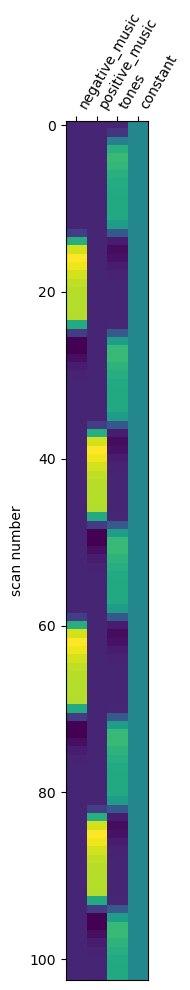

In [200]:
plot_design_matrix(design_matrix)

### FOR ALL RUNS

In [ ]:
# Adjust the oneset for all the runs
duration_time ={}
for i in range(3) : 
    last_event = events_all[events_all['run'] == f'run_{i+1}'].tail(1)
    duration_time[i] = last_event['onset'].values + last_event['duration'].values

size_single_run =  len(events_all[events_all['run'] == f'run_1'])  # Here we takes the first but all of them are the same size

correction=[]
for i in range(3):  
    correction += [duration_time[i][0]*i]*size_single_run

events_all['onset'] += correction
# Drop the response recording  
events = events_all.query("trial_type != 'response'")
# Drop the index of the run
events = events.drop(columns = 'run')


In [183]:
t_start = events['onset'][0]
t_end =events.tail(1)['onset'] + events.tail(1)['duration']

frame_times= np.asarray(list(range(int(t_start.values[0]), int(t_end.values[0]), int(TR))))

Text(0.5, 1.0, 'Design Matrix for 5 Concatenated Runs')

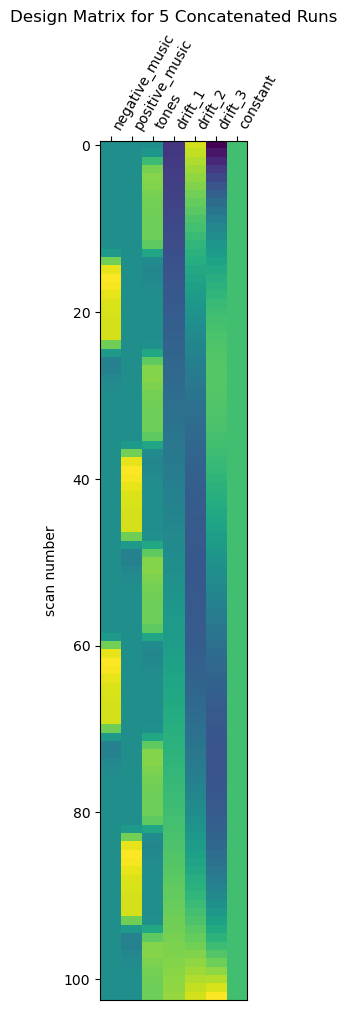

In [ ]:
# Create design matrix using specified HRF model
design_matrix_conc = make_first_level_design_matrix(
    frame_times=frame_times,
    events=events,
    hrf_model='spm', # TODO
    drift_model='polynomial',  # TODO
    drift_order=3  # TODO
)

plot_design_matrix(design_matrix_conc)
plt.title("Design Matrix for 5 Concatenated Runs")

### GLM init

In [ ]:
# Load the data from the preproc 
# concat if needed 

In [ ]:
from nilearn.glm.first_level import FirstLevelModel
drift_model = 'polynomial'  # Model to correct for slow signal drifts # TODO 
high_pass = 0.01  # High-pass filter cutoff, in Hz # TODO 

# Initialize the GLM model with drift correction and AR(1) noise model
fmri_glm = FirstLevelModel(
    t_r=TR,
    noise_model='ar1',
    standardize=False,
    hrf_model='spm',
    drift_model=drift_model,
    high_pass=high_pass
)

In [ ]:
# Create the dictionary of the conditions

# TODO
conditions = {
    'neg_music' : np.array([1, 0, 0, 0, 0, 0, 0]),
    'pos_music' : np.array([0, 1, 0, 0, 0, 0, 0]),
    'tones' : np.array([0, 0, 1, 0, 0, 0, 0]),
}

# Effect of negative musique 
neg_effect = conditions['tones'] - conditions['neg_music']

# Effect of positive musique 
pos_effect = conditions['tones'] - conditions['pos_music']

# positive versus negative musique
pos_neg = conditions['pos_music'] - conditions['neg_music']

In [ ]:
from nilearn.plotting import plot_contrast_matrix

# TODO
plot_contrast_matrix(neg_effect, design_matrix=fmri_glm.design_matrices_[0]) 
plot_contrast_matrix(pos_effect, design_matrix=fmri_glm.design_matrices_[0]) 
plot_contrast_matrix(pos_neg, design_matrix=fmri_glm.design_matrices_[0]) 


AttributeError: 'FirstLevelModel' object has no attribute 'design_matrices_'

In [ ]:
import nibabel as nib
z_map = fmri_glm.compute_contrast(pos_neg, output_type='z_score')

nib.save(z_map, 'z_map_uncorrected.nii.gz')

In [ ]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(fmri_img),
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=3.0,
              display_mode='z', cut_coords=[-3,37,70], black_bg=True,
              title='Active minus Rest (Z>3)')
plt.show()

## DESIGN MATRIX FOR ONE RUN

In [ ]:
TR = 3.0  # Repetition time in seconds
n_scans = 105  # Number of scans in each functional run
frame_times = np.arange(n_scans) * TR  # Array of frame times in seconds

# Define events with onsets, durations, and trial types based on the experiment blocks
# Each block is 33 seconds long and repeats in a specific sequence.
events = pd.DataFrame({
    'onset': [0, 33, 66, 99, 132, 165, 198, 231, 264, 297],  # Onsets in seconds for each condition block
    'duration': [33] * 10,  # Duration for each block (33 seconds each for a total of 5min24sec = 324sec )
    'trial_type': ['pure_tone', 'positive', 'pure_tone', 'negative', 'pure_tone',
                   'positive', 'pure_tone', 'negative', 'pure_tone', 'positive']
})


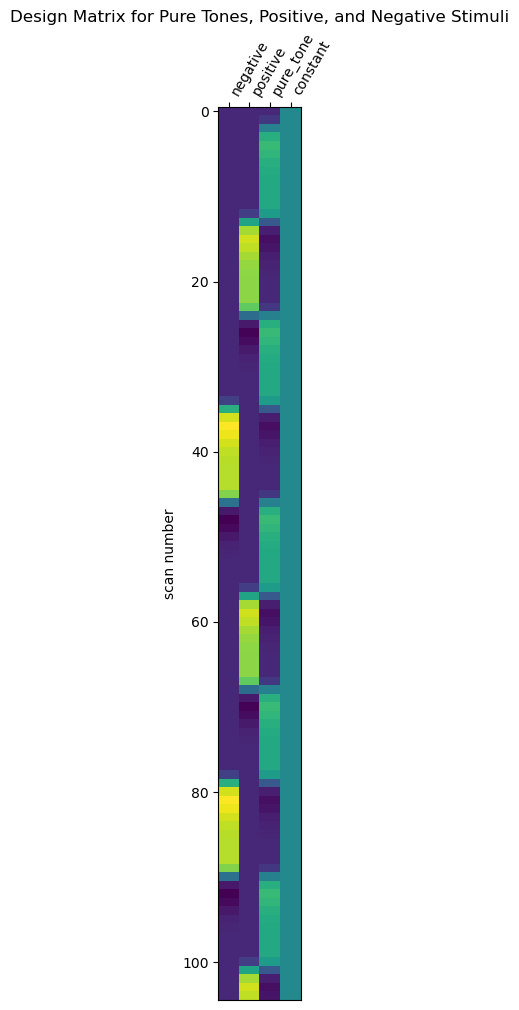

In [ ]:
# Create design matrix using a specified HRF model (SPM)
design_matrix = make_first_level_design_matrix(
    frame_times=frame_times,
    events=events,
    hrf_model='spm',
    drift_model= None,
)

# Plot the design matrix
plot_design_matrix(design_matrix)
plt.title("Design Matrix for Pure Tones, Positive, and Negative Stimuli")
plt.show()

## DESIGN MATRIX FOR 3 RUNS CONCATENATED 

Total Frame Times: 315
    onset  duration trial_type
0       0        33  pure_tone
1      33        33   positive
2      66        33  pure_tone
3      99        33   negative
4     132        33  pure_tone
5     165        33   positive
6     198        33  pure_tone
7     231        33   negative
8     264        33  pure_tone
9     297        33   positive
10    324        33  pure_tone
11    357        33   positive
12    390        33  pure_tone
13    423        33   negative
14    456        33  pure_tone
15    489        33   positive
16    522        33  pure_tone
17    555        33   negative
18    588        33  pure_tone
19    621        33   positive
20    648        33  pure_tone
21    681        33   positive
22    714        33  pure_tone
23    747        33   negative
24    780        33  pure_tone
25    813        33   positive
26    846        33  pure_tone
27    879        33   negative
28    912        33  pure_tone
29    945        33   positive


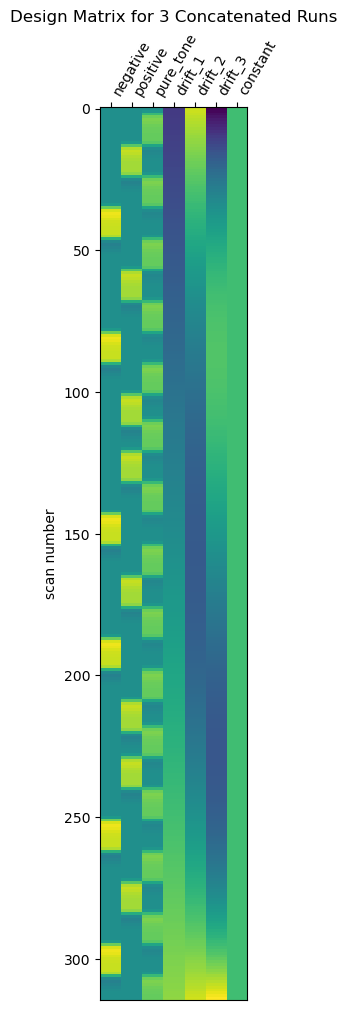

In [119]:
# Parameters
TR = 3.0  # Repetition time in seconds
n_scans_per_run = 105  # Number of scans in each run
n_runs = 3  # Number of runs
total_scans = n_scans_per_run * n_runs  # Total number of scans across all runs

# Create frame times across all runs
frame_times = np.arange(total_scans) * TR  # Now covers all 315 scans

# Define the events for a single run
single_run_events = pd.DataFrame({
    'onset': [0, 33, 66, 99, 132, 165, 198, 231, 264, 297],  # Onset times in seconds for each condition block
    'duration': [33] * 10,  # Duration of each block (33 seconds each)
    'trial_type': ['pure_tone', 'positive', 'pure_tone', 'negative', 'pure_tone',
                   'positive', 'pure_tone', 'negative', 'pure_tone', 'positive']
})

# Concatenate events for all runs, adjusting onset times for each
all_events = pd.concat([
    single_run_events.assign(onset=single_run_events['onset'] + run * 324)  # Shift onset by 324s per run
    for run in range(n_runs)
], ignore_index=True)

# Confirm all_events and frame_times span the entire concatenated run length
print(f"Total Frame Times: {len(frame_times)}")  # Should be 315
print(all_events)

# Create design matrix using specified HRF model
design_matrix_conc = make_first_level_design_matrix(
    frame_times=frame_times,
    events=all_events,
    hrf_model='spm',
    drift_model='polynomial',  # a choisir !
    drift_order=3 
)

# Plot the design matrix
plot_design_matrix(design_matrix_conc)
plt.title("Design Matrix for 3 Concatenated Runs")
plt.show()

## DRIFT MODEL SELECTION 
A **polynomial drift model** captures slow changes in the scanner signal without affecting task signals, which is useful for longer scans, especially with a TR of around 3 seconds that allows us to model these low-frequency drifts well. **Motion correction regressors** remove artifacts from any head movement, keeping task-related brain activity clear. PAS ENCORE MIS LES MOTIONS REGRESSORS 

## INITIALIZE GLM 

In [ ]:
from nilearn.glm.first_level import FirstLevelModel
drift_model = 'polynomial'  # Model to correct for slow signal drifts
high_pass = 0.01  # High-pass filter cutoff, in Hz

# Initialize the GLM model with drift correction and AR(1) noise model
fmri_glm = FirstLevelModel(
    t_r=TR,
    noise_model='ar1',
    standardize=False,
    hrf_model='spm',
    drift_model=drift_model,
    high_pass=high_pass
)

In [ ]:
#extract the preprocessed func file 
import nibabel as nib
func_img = nib.load("/Users/poseidon/Desktop/concatenated_smoothed.nii.gz")

# Fit the GLM to the functional image and design matrix
fmri_glm = fmri_glm.fit(func_img, design_matrices=design_matrix_conc)

FileNotFoundError: No such file or no access: '/Users/poseidon/Desktop/concatenated_smoothed.nii.gz'

## BETA AND STATISTICAL MAP OF THE REGRESSOR - A faire 

In [ ]:
from nilearn import plotting

# Retrieve beta maps and statistical maps for each regressor
regressor_names = design_matrix_conc.columns  # List of regressors from design matrix

for regressor in regressor_names:
    # Get the contrast for the regressor, which includes both beta and statistical maps
    contrast = fmri_glm.compute_contrast(regressor, output_type='all')
    
    # Display beta map
    print(f"Displaying beta map for: {regressor}")
    plotting.plot_stat_map(
        contrast['effect_size'], title=f"Beta Map for {regressor}", colorbar=True
    )
    
    # Display statistical map (t-stat map)
    print(f"Displaying statistical map for: {regressor}")
    plotting.plot_stat_map(
        contrast['stat'], title=f"Statistical Map for {regressor}", colorbar=True
    )


ValueError: The model has not been fit yet.